# 二维库埃特流

[![下载Notebook](https://mindspore-website.obs.cn-north-4.myhuaweicloud.com/website-images/master/resource/_static/logo_notebook.png)](https://obs.dualstack.cn-north-4.myhuaweicloud.com/mindspore-website/notebook/master/mindflow/zh_cn/cfd/mindspore_couette.ipynb)&emsp;[![下载样例代码](https://mindspore-website.obs.cn-north-4.myhuaweicloud.com/website-images/master/resource/_static/logo_download_code.png)](https://obs.dualstack.cn-north-4.myhuaweicloud.com/mindspore-website/notebook/master/mindflow/zh_cn/cfd/mindspore_couette.py)&emsp;[![查看源文件](https://mindspore-website.obs.cn-north-4.myhuaweicloud.com/website-images/master/resource/_static/logo_source.png)](https://gitee.com/mindspore/docs/blob/master/docs/mindflow/docs/source_zh_cn/cfd/couette.ipynb)

本案例要求**MindSpore版本 >= 2.0.0**调用如下接口: *mindspore.jit，mindspore.jit_class*。

在流体力学中，库埃特流是粘性流体在两个相对运动的表面之间的流动，表面的相对运动对流体施加剪应力并引起流动，在流动方向上也可以施加压力梯度。

库埃特流动在某些实际问题中也有应用，如地球的地幔和大气运动，以及轻负荷滑动轴承中的流动。库埃特流也可应用于粘度测定，证明可逆性等。

库埃特流以19世纪末法国昂热大学物理学教授莫里斯·库埃特的名字命名的。


## 问题描述

二维库埃特流动的定义为:

$$
\frac{\partial u}{\partial t} = \frac{\partial^2 u}{\partial y^2}
$$

模拟的初始条件为

$$
u(y, 0), \quad 0<y<h
$$

边界条件:

$$
u(0, t)=0, \quad u(h, t)=U, \quad t>0
$$

本案例中`src`包可以在[src](https://gitee.com/mindspore/mindscience/tree/master/MindFlow/applications/cfd/couette/src)下载。


In [1]:
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.legend_handler import HandlerTuple

from mindspore import context
from mindflow import load_yaml_config
from mindflow import cfd
from mindflow.cfd.runtime import RunTime
from mindflow.cfd.simulator import Simulator

from src.ic import couette_ic_2d

context.set_context(device_target="GPU", device_id=3)

## 定义Simulator和RunTime

网格、材料、仿真时间、边界条件和数值方法的设置在文件[couette.yaml](https://gitee.com/mindspore/mindscience/blob/master/MindFlow/applications/cfd/couette/couette.yaml)中。

In [2]:
config = load_yaml_config('couette.yaml')
simulator = Simulator(config)
runtime = RunTime(config['runtime'], simulator.mesh_info, simulator.material)

## 理论解

通过抽取稳态解，使问题趋于齐次，应用分离变量法可以求得理论解：

$$
u(y,t)=U\frac{y}{h}-\frac{2U}{\pi}\sum_{i=1}^{\infty}{\frac{1}{n}e^{-n^2\pi^2\frac{\nu t}{h^2}}sin \left[ n\pi (1-\frac{y}{h}) \right] }
$$

In [3]:
def label_fun(y, t):
    nu = 0.1
    h = 1.0
    u_max = 0.1
    coe = 0.0
    for i in range(1, 100):
        coe += np.sin(i*np.pi*(1 - y/h))*np.exp(-(i**2)*(np.pi**2)*nu*t/(h**2))/i
    return u_max*y/h - (2*u_max / np.pi)*coe

## 初始条件

根据网格坐标确定初始条件。

In [4]:
mesh_x, mesh_y, _ = simulator.mesh_info.mesh_xyz()
pri_var = couette_ic_2d(mesh_x, mesh_y)
con_var = cfd.cal_con_var(pri_var, simulator.material)

## 执行仿真

执行仿真，并在 $t=0.005s, t=0.5s, t=0.05s, t=0.005s$ 时与理论解相比较。

current time = 0.000000, time step = 0.000200
current time = 0.000200, time step = 0.000200
current time = 0.000400, time step = 0.000200
current time = 0.000600, time step = 0.000200
current time = 0.000800, time step = 0.000200
current time = 0.001000, time step = 0.000200
current time = 0.001200, time step = 0.000200
current time = 0.001400, time step = 0.000200
current time = 0.001600, time step = 0.000200
current time = 0.001800, time step = 0.000200
current time = 0.002000, time step = 0.000200
current time = 0.002200, time step = 0.000200
current time = 0.002400, time step = 0.000200
current time = 0.002600, time step = 0.000200
current time = 0.002800, time step = 0.000200
current time = 0.003000, time step = 0.000200
current time = 0.003200, time step = 0.000200
current time = 0.003400, time step = 0.000200
current time = 0.003600, time step = 0.000200
current time = 0.003800, time step = 0.000200
current time = 0.004000, time step = 0.000200
current time = 0.004200, time step

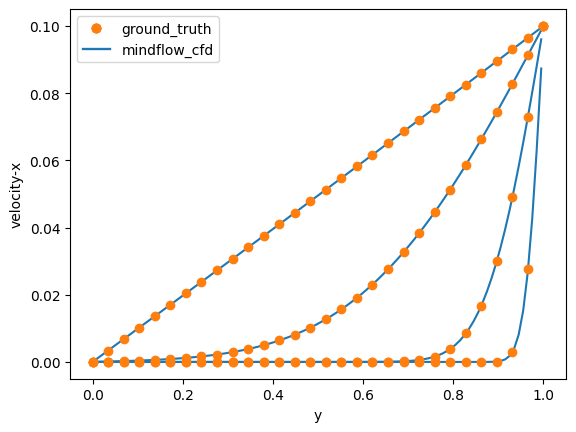

In [5]:
dy = 1/config['mesh']['ny']
cell_centers = np.linspace(dy/2, 1 - dy/2, config['mesh']['ny'])
label_y = np.linspace(0, 1, 30, endpoint=True)
label_plot_list = []
simulation_plot_list = []
plot_step = 3

fig, ax = plt.subplots()

while runtime.time_loop(pri_var):
    runtime.compute_timestep(pri_var)
    con_var = simulator.integration_step(con_var, runtime.timestep)
    pri_var = cfd.cal_pri_var(con_var, simulator.material)
    runtime.advance()

    if np.abs(runtime.current_time.asnumpy() - 5.0*0.1**plot_step) < 0.1*runtime.timestep:
        label_u = label_fun(label_y, runtime.current_time.asnumpy())
        simulation_plot_list.append(plt.plot(cell_centers, pri_var.asnumpy()[1, 0, :, 0], color='tab:blue')[0])
        label_plot_list.append(plt.plot(label_y, label_u, label='ground_truth', marker='o', linewidth=0, color='tab:orange')[0])
        plot_step -= 1


plt.legend(loc='best')
ax.legend([tuple(label_plot_list), tuple(simulation_plot_list)], ['ground_truth', 'mindflow_cfd'], numpoints=1, handler_map={tuple: HandlerTuple(ndivide=1)})
plt.xlabel('y')
plt.ylabel('velocity-x')
plt.savefig('couette.jpg')